In [7]:
import numpy as np
from utils import load_object
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
num_seeds = 12

path = '/home/taghianj/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'
# path = '/home/mehran/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph'

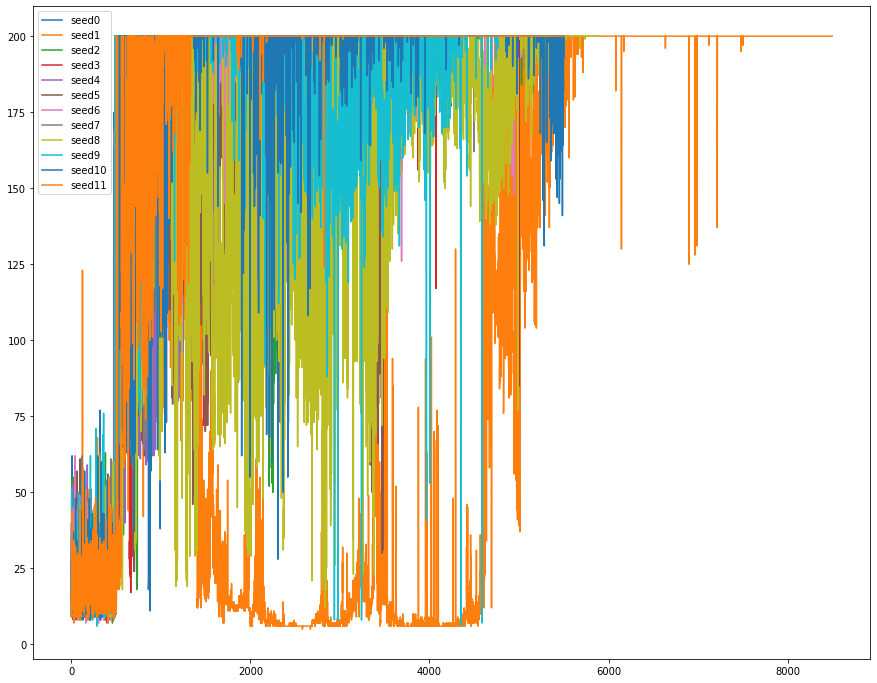

In [5]:
plt.figure(figsize=[15,12])
for s in range(num_seeds):
    data = load_object(f'{path}/seed{s}/train.pkl')[:, 3]
    print(data.shape[0])
    plt.plot(data, label=f'seed{s}')

plt.legend()

In [9]:
# data = load_object("/home/me/Documents/SAC_GCN/Data/cedar/Data/Walker2d-v2/graph/seed0/train.pkl")
bf = load_object("/home/taghianj/Documents/SAC_GCN/Data/buffer.pkl")


# os.path.getsize("/home/taghianj/Documents/SAC_GCN/Data/cedar/Walker2d-v2/graph/seed0/buffer.pkl")

3129748029

In [15]:
import pickle, gzip
file_path = "/home/taghianj/Documents/SAC_GCN/Data/buffer.pkl"
buffer = None
with open(file_path, 'rb') as f:
    p = pickle.Unpickler(f)
    buffer = p.load()

In [17]:
from Graph_SAC.replay_memory import ReplayMemory

In [18]:
rm = ReplayMemory(1000000, 0)

In [19]:
rm.load_buffer("/home/taghianj/Documents/SAC_GCN/Data/buffer.pkl")

In [16]:
len(buffer)

1000000

In [10]:
data = pd.read_csv("/home/mehran/Documents/SAC_GCN/Data/Hopper-v2/thigh_joint/seed2/eval.csv")

In [11]:
data

,num_episodes,num_steps,num_updates,eval_reward
0,9.0,194.0,0.0,121.254049
1,19.0,432.0,175.0,109.890246
2,29.0,641.0,384.0,68.919956
3,39.0,898.0,641.0,46.692771
4,49.0,1130.0,873.0,45.844892
...,...,...,...,...
995,9959.0,1776840.0,1776583.0,721.098825
996,9969.0,1778792.0,1778535.0,691.768661
997,9979.0,1780701.0,1780444.0,718.182107
998,9989.0,1782675.0,1782418.0,681.614950
